In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_RAW = os.path.join(os.getcwd(), os.pardir, 'data', 'raw')

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *

# `data/raw/Data_request_20171201.xlsx`
### WHO Raw Subnational Data

This is the raw subnational data provided by the WHO.

In [3]:
dtypes = {
    "Iso Code": 'category',
    "Country Name": 'category',
    'WHO Region': 'category',
    'Year': 'int',
    'Vaccine Type': 'category',
    'Admin1': 'category',
    'Admin2': 'category',
    'DenomType': 'category',
    'Denominator': 'float',
    'Numerator': 'float',
    'Coverage': 'float'
}

In [4]:
df = pd.read_excel(os.path.join(DATA_RAW, 'Data_request_20171201.xlsx'), dtype=dtypes, na_values=[-2222, -4444])

print(f"Data has {df.shape[0]} rows and {df.shape[1]} columns")

df.head()

Data has 178333 rows and 11 columns


Iso Code Country Name WHO Region  Year Vaccine Type Admin1      Admin2  \
0      AFG  Afghanistan       EMRO  2016          BCG    NaN    Aab Band   
1      AFG  Afghanistan       EMRO  2016          BCG    NaN  Aab Kamari   
2      AFG  Afghanistan       EMRO  2016          BCG    NaN      Aaqcha   
3      AFG  Afghanistan       EMRO  2016          BCG    NaN      Acheen   
4      AFG  Afghanistan       EMRO  2016          BCG    NaN    Adraskan   

  DenomType  Denominator  Numerator   Coverage  
0       1.0       1266.0        NaN  51.801245  
1       1.0       4599.0        NaN  94.674670  
2       1.0       5674.0        NaN  72.116489  
3       1.0       4846.0        NaN  35.203626  
4       1.0       3557.0        NaN  81.468327

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178333 entries, 0 to 178332
Data columns (total 11 columns):
Iso Code        178333 non-null category
Country Name    178333 non-null category
WHO Region      178333 non-null category
Year            178333 non-null int64
Vaccine Type    178333 non-null category
Admin1          171572 non-null category
Admin2          169973 non-null category
DenomType       155561 non-null category
Denominator     172440 non-null float64
Numerator       49797 non-null float64
Coverage        140993 non-null float64
dtypes: category(7), float64(3), int64(1)
memory usage: 8.2 MB


In [6]:
df.describe(include='all')

Iso Code Country Name WHO Region      Year Vaccine Type   Admin1  \
count    178333       178333     178333  178333.0       178333   171572   
unique      136          136          6       NaN           32     2217   
top         ETH     Ethiopia       AFRO       NaN         DTP3  Oromiya   
freq      18348        18348      88374       NaN        22895     6644   
mean        NaN          NaN        NaN    2016.0          NaN      NaN   
std         NaN          NaN        NaN       0.0          NaN      NaN   
min         NaN          NaN        NaN    2016.0          NaN      NaN   
25%         NaN          NaN        NaN    2016.0          NaN      NaN   
50%         NaN          NaN        NaN    2016.0          NaN      NaN   
75%         NaN          NaN        NaN    2016.0          NaN      NaN   
max         NaN          NaN        NaN    2016.0          NaN      NaN   

        Admin2  DenomType    Denominator      Numerator       Coverage  
count   169973   155561.0  172440.000000   49797.000000  140993.000000  
unique   20685        4.0            NaN            NaN            NaN  
top      Samba        2.0            NaN            NaN            NaN  
freq        56   107507.0            NaN            NaN            NaN  
mean       NaN        NaN    7240.041696    3128.050184      94.519876  
std        NaN        NaN   15521.187017   15482.647383     177.562789  
min        NaN        NaN       0.000000       0.000000       0.000000  
25%        NaN        NaN     685.000000      74.000000      75.045427  
50%        NaN        NaN    3237.000000     221.000000      92.471835  
75%        NaN        NaN    7421.000000     717.000000     102.540107  
max        NaN        NaN  659260.000000  407112.000000   35377.272727

In [7]:
# Countries

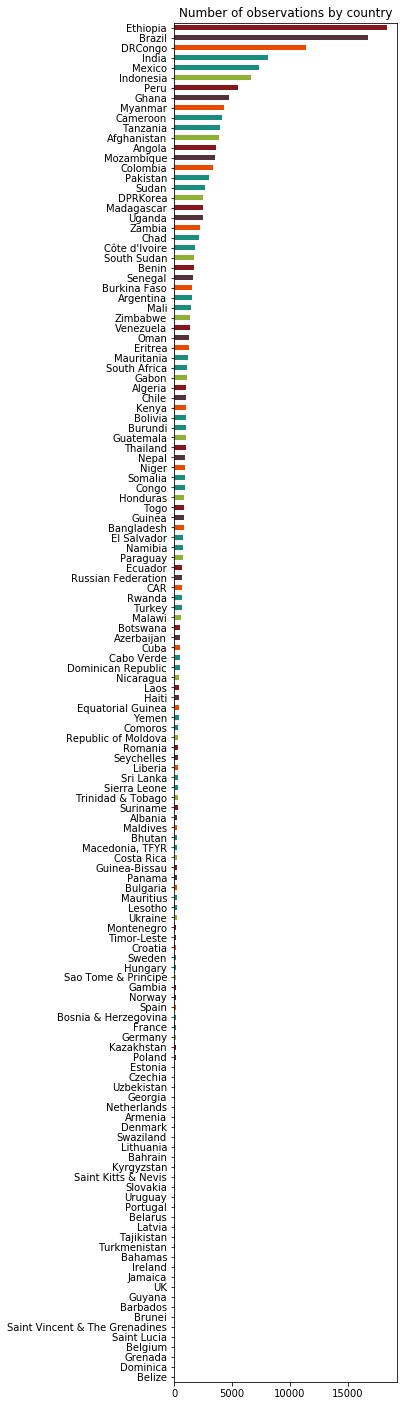

In [8]:
df['Country Name'].value_counts(ascending=True).plot.barh(figsize=(4, 25))
plt.title("Number of observations by country");

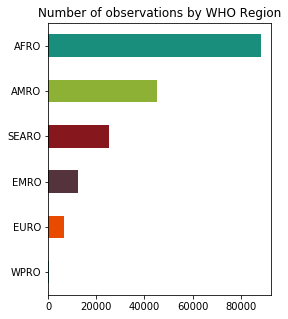

In [9]:
df['WHO Region'].value_counts(ascending=True).plot.barh(figsize=(4, 5))
plt.title("Number of observations by WHO Region");

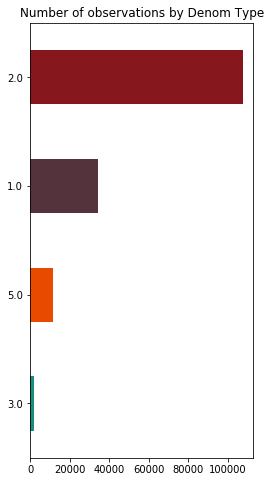

In [10]:
# Denom Type
df['DenomType'].value_counts(ascending=True).plot.barh(figsize=(4, 8))
plt.title("Number of observations by Denom Type");

In [11]:
df['recalc_numerator'] = np.where(pd.notnull(df.Numerator),
                                  df.Numerator,
                                  (df.Coverage / 100.) * df.Denominator)

# Geography

In [12]:
(df.groupby(['WHO Region'])['Country Name'].nunique())

WHO Region
AFRO     46
AMRO     32
EMRO      7
EURO     38
SEARO    11
WPRO      2
Name: Country Name, dtype: int64

In [13]:
# drop 5 rows with no regional information
df['available_admin'] = np.where(pd.notnull(df.Admin2),
                                 df.Admin2,
                                 df.Admin1)

df = df[pd.notnull(df.available_admin)]

In [14]:
df.groupby(['Country Name'])['available_admin'].nunique().quantile(0.25) #.plot.hist(bins=100)#sort_values()

14.0

In [15]:
more_than_1_level = lambda x: x.nunique() > 1

rollup = (df.groupby(['Country Name'])[['Admin1', 'Admin2']]
            .agg({'Admin1': more_than_1_level, 'Admin2': more_than_1_level, 'WHO Region': 'first'}))

rollup = rollup.assign(both=lambda x: x.Admin1 & x.Admin2)


rollup

print(f"{(~rollup.Admin2 & rollup.Admin1).sum()} countries with just Admin1")
print(f"{(rollup.Admin2 & ~rollup.Admin1).sum()} countries with just Admin2")
print(f"{rollup.both.sum()} countries with both")

# print(f"{((rollup.Admin1 > 1) & (rollup.Admin2 > 1)).sum()} countries with both")

# print(f"{} countries with just Admin1")


#rollup#.reset_index().pivot_table(index='WHO Region', columns=['Admin1', 'Admin2'])

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


39 countries with just Admin1
16 countries with just Admin2
81 countries with both


In [16]:
populations = pd.read_html(os.path.join(DATA_RAW,
                                        os.pardir,
                                        'external',
                                        'wikipedia_country_population_table.html'))[0]

populations.head()

Rank Country or area UN continental region[1] UN statistical region[1]  \
0  â           World                      â                      â   
1    1        China[a]                     Asia             Eastern Asia   
2    2           India                     Asia            Southern Asia   
3    3   United States                 Americas         Northern America   
4    4       Indonesia                     Asia       South-Eastern Asia   

   Population (1 July 2016)[2]  Population (1 July 2017)[2]  \
0                   7466964280                   7550262101   
1                   1403500365                   1409517397   
2                   1324171354                   1339180127   
3                    322179605                    324459463   
4                    261115456                    263991379   

                        Change  
0  7000111555135228260â +1.1%  
1  6999428716097982630â +0.4%  
2  7000113344643460699â +1.1%  
3  6999707635730076710â +0.7%  
4  7000110139899186970â +1.1%

In [17]:
remaps = {
    'bosnia and herzegovina': 'bosnia & herzegovina',
    'cape verde': 'cabo verde',
    'central african republic': 'car',
    'czech republic': 'czechia',
    "ivory coast": "côte d'ivoire",
    "north korea": "dprkorea",
    "democratic republic of the congo": "drcongo",
    "the gambia": "gambia",
    "republic of macedonia": "macedonia, tfyr",
    "moldova": "republic of moldova",
    "russia": "russian federation",
    "saint kitts and nevis": "saint kitts & nevis",
    "saint vincent and the grenadines": "saint vincent & the grenadines",
    "sao tome and principe": "sao tome & principe",
    "east timor": "timor-leste",
    "trinidad and tobago": "trinidad & tobago",
    "united kingdom": "uk",
}


remove_footnotes = lambda s: s[:s.find('[')] if '[' in s else s

df['normalized_country'] = df['Country Name'].str.lower()
populations['normalized_country'] = populations['Country or area'].str.lower().apply(remove_footnotes).replace(remaps)

np.setdiff1d(populations.normalized_country.unique(),
             df.normalized_country.unique())


(populations[populations.normalized_country.isin(np.setdiff1d(populations.normalized_country.unique(),
             df.normalized_country.unique()))].sort_values(
                ['UN continental region[1]', 'Population (1 July 2017)[2]'], ascending=False))['UN continental region[1]'].value_counts()

Asia        23
Oceania     23
Americas    21
Europe      20
Africa      10
â          1
Name: UN continental region[1], dtype: int64

In [18]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()

to_plot = df.groupby('Iso Code')['Country Name'].agg(lambda x: True)

data = [ dict(
        type = 'choropleth',
        locations = to_plot.index,
        z = to_plot,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.0
            ) ),
      ) ]

layout = dict(
    title = 'Map',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
iplot( fig, validate=False, filename='d3-world-map' )

In [19]:
GAVI = pd.read_csv(os.path.join(DATA_RAW, os.pardir, 'external', 'GAVI_2016.csv'))
GAVI.sort_values('committed', ascending=False)


country    committed
22                                      Nigeria  186615500.0
21                                     Pakistan  120927500.0
52  Democratic Republic of the Congo (Kinshasa)  100590293.0
49                                     Ethiopia   92570000.0
67                                   Bangladesh   74755926.0
40                                        India   59410000.0
5                   United Republic of Tanzania   50930742.0
6                                        Uganda   46436500.0
10                                        Sudan   45307207.0
71                                  Afghanistan   40103734.0
27                                   Mozambique   33267864.0
38                                        Kenya   32254000.0
30                                         Mali   30771018.0
23                                        Niger   28546042.0
26                                      Myanmar   28095000.0
32                                   Madagascar   26857000.0
1                                        Zambia   25188413.0
63                                 Burkina Faso   23873310.0
25                                        Nepal   21777000.0
46                                        Ghana   19273650.0
55                                Cote d'Ivoire   18417962.0
4                                    Uzbekistan   17257890.0
16                                      Senegal   16994444.0
61                                     Cambodia   16910958.0
2                                         Yemen   16605458.0
31                                       Malawi   16055601.0
60                                     Cameroon   14935500.0
18                                       Rwanda   14015883.0
0                                      Zimbabwe   11121399.0
39                                    Indonesia   10359000.0
..                                          ...          ...
64                                      Bolivia    5028776.0
29                                   Mauritania    4017500.0
42                                        Haiti    3931726.0
48                                       Gambia    3530606.0
20                             Papua New Guinea    3527148.0
41                                     Honduras    3466624.0
33                                      Liberia    3353500.0
13                                      Somalia    3289000.0
50                                      Eritrea    3140000.0
44                                Guinea-Bissau    2851000.0
56             Congo, Republic of (Brazzaville)    2389405.0
45                                       Guinea    2344500.0
24                                    Nicaragua    2251000.0
36                          Kyrgyzstan Republic    2213769.0
68                                   Azerbaijan    2015000.0
34                                      Lesotho    1317860.0
51                                     Djibouti    1157500.0
17                        Sao Tome and Principe    1054349.0
14                              Solomon Islands     919310.0
47                                      Georgia     885305.0
54                                         Cuba     763000.0
8                      Timor-Leste (East Timor)     751385.0
19                          Republic of Moldova     626675.0
57                                      Comoros     592004.0
69                                      Armenia     514000.0
43                                       Guyana     305000.0
11                                    Sri Lanka     187500.0
28                                     Mongolia     184500.0
65                                       Bhutan      48000.0
37                                     Kiribati      26500.0

[72 rows x 2 columns]

In [20]:
df.normalized_country.sort_values().unique()

array(['afghanistan', 'albania', 'algeria', 'angola', 'argentina',
       'armenia', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh',
       'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bhutan',
       'bolivia', 'bosnia & herzegovina', 'botswana', 'brazil', 'brunei',
       'bulgaria', 'burkina faso', 'burundi', 'cabo verde', 'cameroon',
       'car', 'chad', 'chile', 'colombia', 'comoros', 'congo',
       'costa rica', 'croatia', 'cuba', 'czechia', "côte d'ivoire",
       'denmark', 'dominica', 'dominican republic', 'dprkorea', 'drcongo',
       'ecuador', 'el salvador', 'equatorial guinea', 'eritrea',
       'estonia', 'ethiopia', 'france', 'gabon', 'gambia', 'georgia',
       'germany', 'ghana', 'grenada', 'guatemala', 'guinea',
       'guinea-bissau', 'guyana', 'haiti', 'honduras', 'hungary', 'india',
       'indonesia', 'ireland', 'jamaica', 'kazakhstan', 'kenya',
       'kyrgyzstan', 'laos', 'latvia', 'lesotho', 'liberia', 'lithuania',
       'macedonia, tfyr', 'madaga

In [21]:
GAVI.country.nunique()

72

In [22]:
gavi_rempas = {
    'central african republic': 'car',
    'congo, republic of (brazzaville)': 'congo',
    "cote d'ivoire": "côte d'ivoire",
    "democratic people's republic of korea": "dprkorea",
    "democratic republic of the congo (kinshasa)": "drcongo",
    "kyrgyzstan republic": "kyrgyzstan",
    "lao people's democratic republic": "laos",
    "sao tome and principe": "sao tome & principe",
    "timor-leste (east timor)": "timor-leste",
    "united republic of tanzania": "tanzania",
}


ms = np.setdiff1d(GAVI.country.str.lower().replace(gavi_rempas).sort_values(),
                  df.normalized_country.sort_values().unique())

In [23]:
", ".join(map(str.capitalize, ms))

'Cambodia, Djibouti, Kiribati, Mongolia, Nigeria, Papua new guinea, Solomon islands, Viet nam'

## Vaccines

In [ ]:
# vaccine metadata on the Sheet "Tidy"
#  https://docs.google.com/spreadsheets/d/1X769pklcNg3NI5is-IRh6cCVXV3p03o9MhSaQpM2c7E/edit#gid=303669444

vax_meta = pd.read_clipboard(header=None)
vax_meta.columns = ['group', 'vaccine', 'timing']


df['Vaccine Type'].value_counts(ascending=True).plot.barh(figsize=(4, 8))
plt.title("Number of observations by Vaccine Type");

In [ ]:
df['indicator'] = 1

In [ ]:
df = df.merge(vax_meta, how='left', left_on='Vaccine Type', right_on='vaccine')

In [ ]:
df.shape

In [ ]:
df[df['Vaccine Type'] == 'YFV']

In [ ]:
df.shape

In [ ]:
df.groupby('group').recalc_numerator.sum()

In [ ]:
to_plot

In [ ]:
FS = 8

with styled_fig_ax(size='wide', font_size=FS, x_formatter=comma_func_formatter(), zero_lines=False) as ax:
    to_plot = df.pivot_table(dropna=False,
                             columns=['timing'],
                             index=['group'],
                             values='recalc_numerator',
                             fill_value=0,
                             aggfunc='sum')
    
    # sorted
    to_plot = to_plot.loc[to_plot.sum(axis=1).sort_values().index, :]
    
    labeled_bar(ax,
                to_plot,
                font_size=FS,
                horizontal=True,
                label_formatter=comma_func_formatter(),
                stacked=True)
    
    ax.set_ylabel('')
    ax.set_title('Number of Reported Vaccinations by Vaccine Type')

In [ ]:
# confirm that for every country, the same vaccines are reported at every admin-2 level region
(df.groupby(['Country Name', 'Vaccine Type']).available_admin.nunique().unstack(-1).nunique(axis=1) == 1).all()

In [ ]:
df['Vaccine Type'].nunique()

In [ ]:
df['group'].nunique()

In [ ]:
coutries_reporting = (df.groupby(['group'])['Country Name'].nunique() / df['Country Name'].nunique()).sort_values()

with styled_fig_ax(size='tall', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                coutries_reporting,
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['orange'])
    
    
    ax.set_ylabel('')
    ax.set_title('Percent of represented countries reporting vaccines by type')


In [ ]:
coutries_reporting = (df.groupby(['timing']).recalc_numerator.sum().sort_values())

with styled_fig_ax(size='tall', font_size=FS, x_formatter=comma_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                coutries_reporting,
                font_size=FS,
                horizontal=True,
                label_formatter=comma_func_formatter(),
                color=PALETTE['green'])
    
    
    ax.set_ylabel('')
    ax.set_title('Vaccinations by timing')


In [ ]:
top_10_vaccines = (df.groupby(['Vaccine Type']).recalc_numerator.sum().sort_values().tail(10))

with styled_fig_ax(size='quarter', font_size=FS, x_formatter=comma_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                top_10_vaccines,
                font_size=FS,
                horizontal=True,
                label_formatter=comma_func_formatter(),
                color=PALETTE['purple'])
    
    
    ax.set_ylabel('')
    ax.set_title('Top 10 Indivudal Vaccines by Number of Doses')


In [ ]:
top_10_by_pct_cout = ((df.groupby(['Vaccine Type'])['Country Name'].nunique() / df['Country Name'].nunique())
                         .sort_values()
                         .tail(10))

with styled_fig_ax(size='quarter', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                top_10_by_pct_cout,
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['red'])
    
    
    ax.set_ylabel('')
    ax.set_title('Top 10 Individual Vaccines by Percent of Countries Reporting')


In [ ]:
def _all_reported(sub_df):
    admin_vax = sub_df.groupby(['available_admin', 'Vaccine Type']).indicator.any().unstack().fillna(0)
    return admin_vax.sum() / admin_vax.shape[0]


bad = (df.groupby(['Country Name']).apply(_all_reported))
(bad == 1).all()


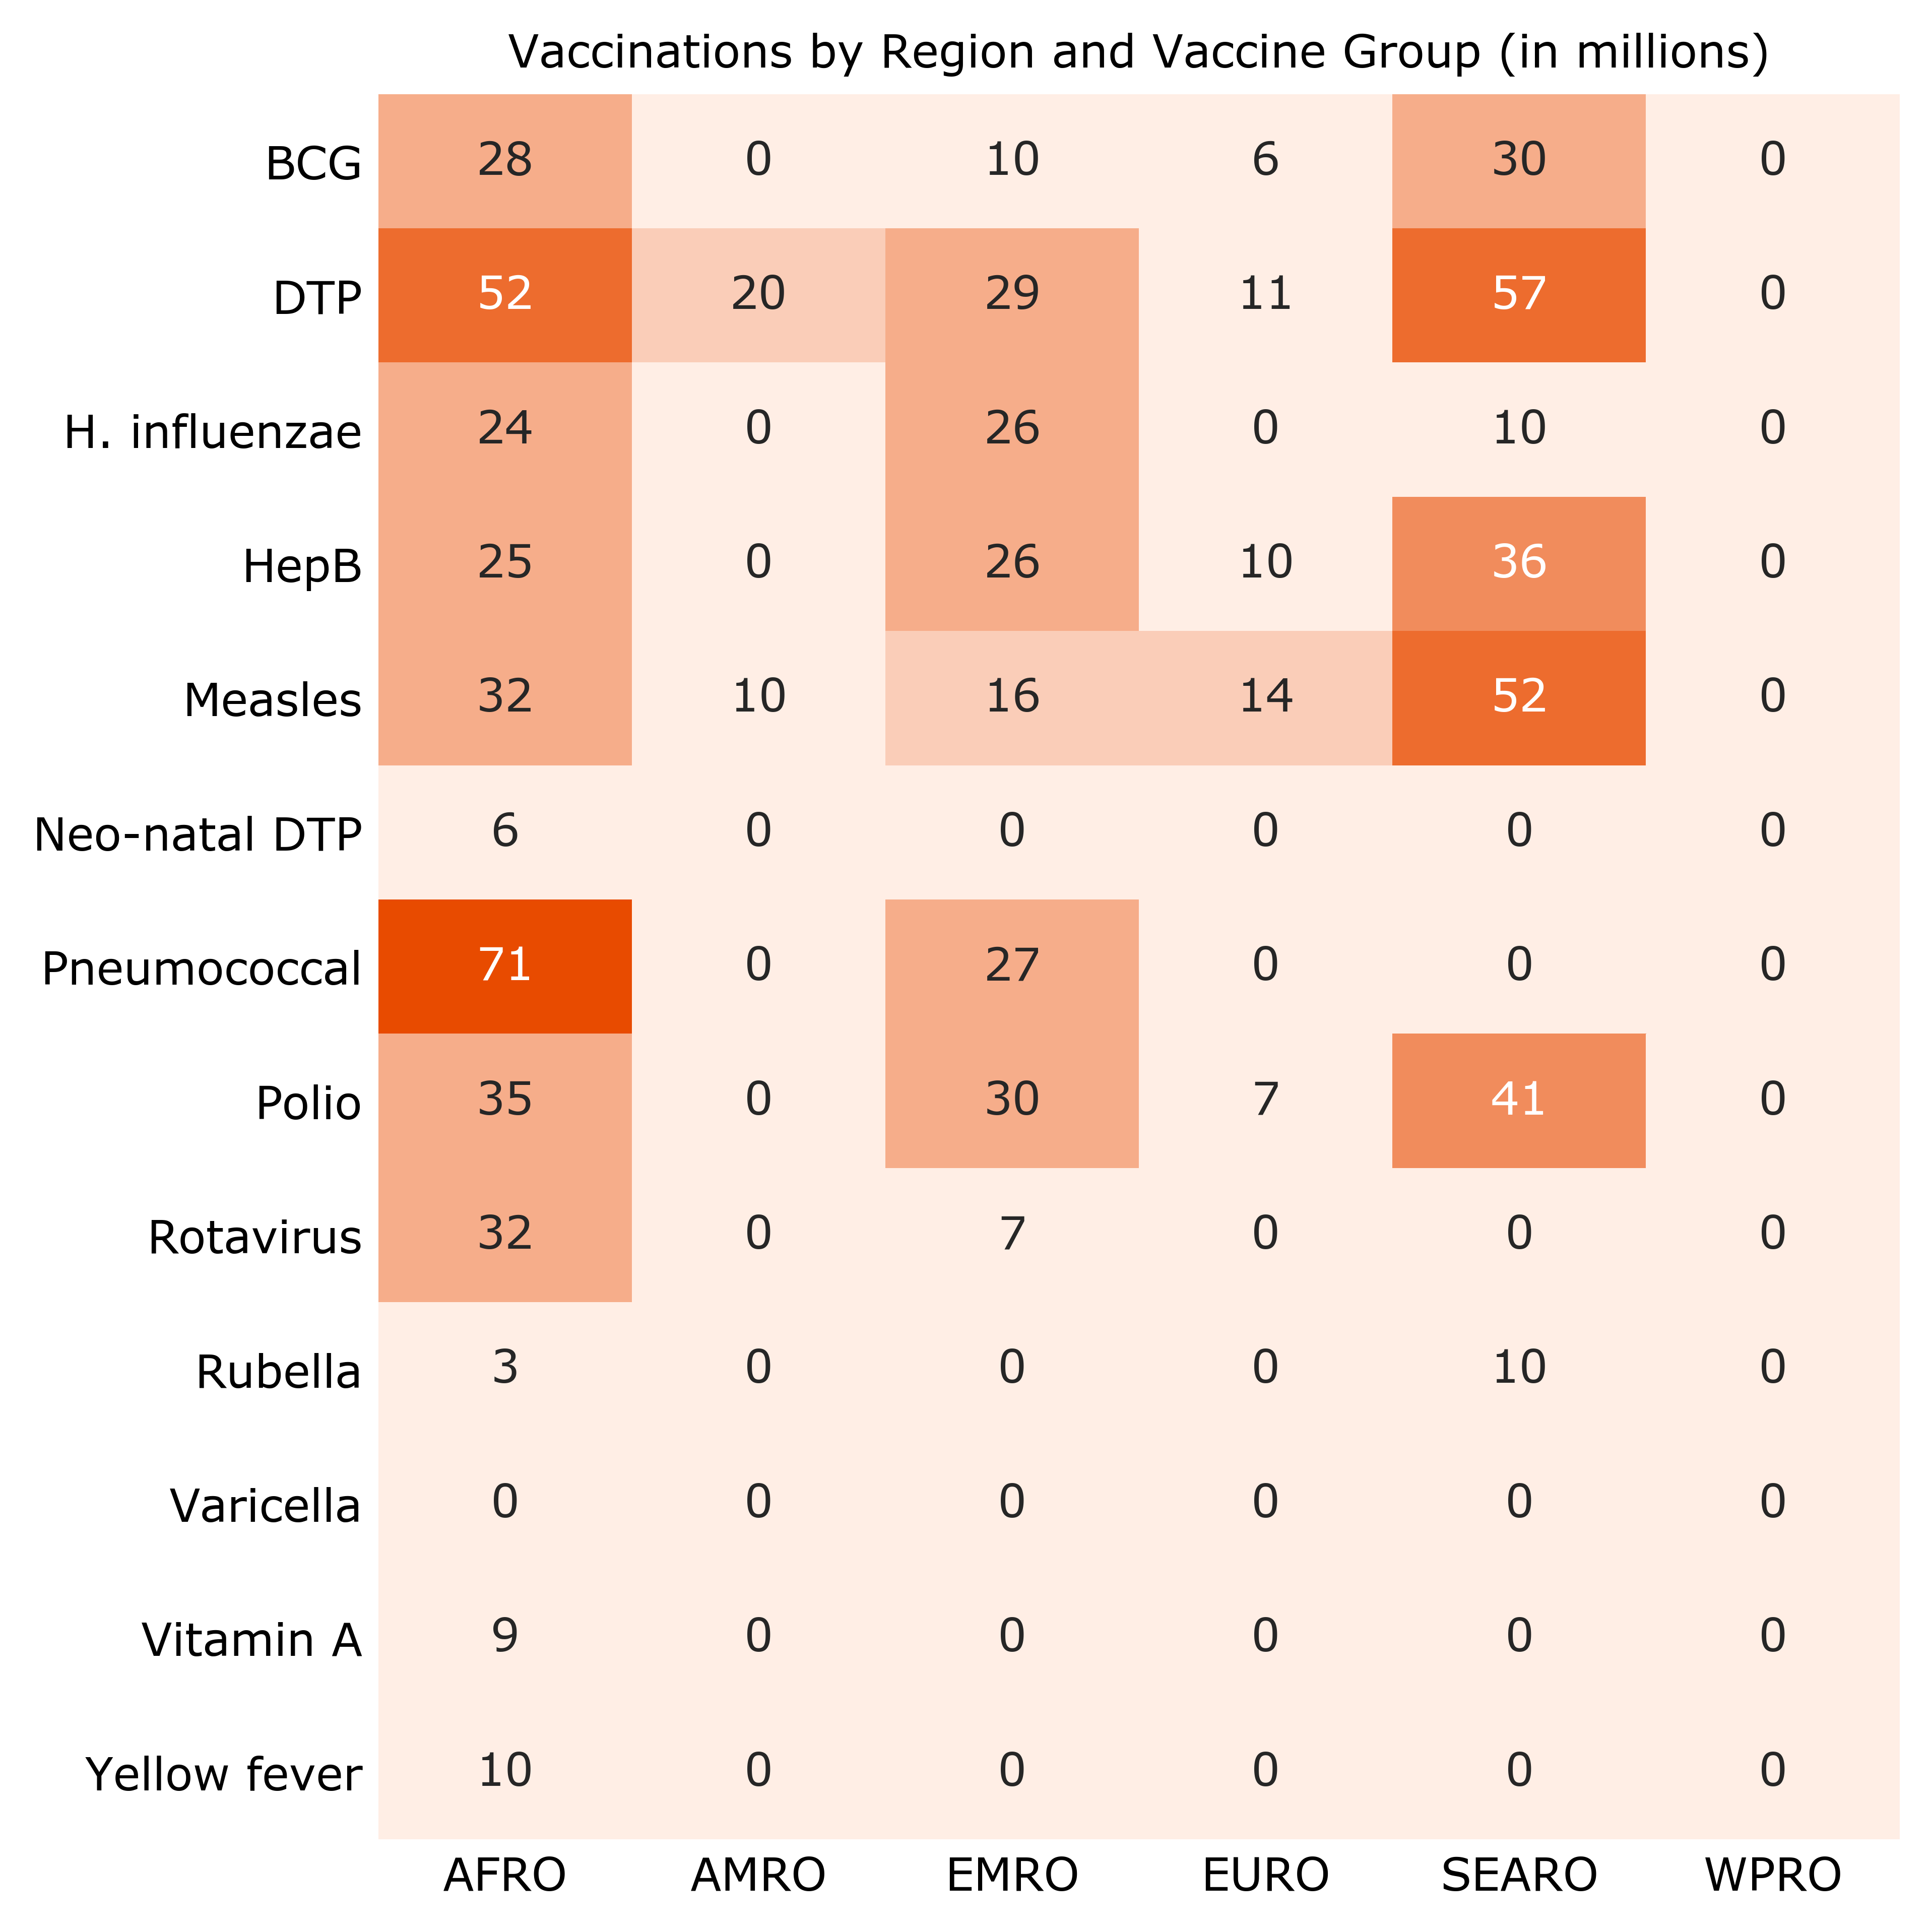

In [43]:
to_plot = df.groupby(['group', 'WHO Region']).recalc_numerator.sum().unstack().fillna(0)

with styled_fig_ax(size='square', font_size=FS, zero_lines=False, seaborn=True):
    sns.heatmap(to_plot / 1e6,
                annot=True,
                fmt=',.0f',
                cmap=sns.light_palette(PALETTE['orange']),
                cbar=False)
    
    ax = plt.gca()
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    ax.set_title('Vaccinations by Region and Vaccine Group (in millions)')

# Numerators

In [44]:
reports_numerators = df.groupby('Country Name').Numerator.apply(lambda x: pd.notnull(x).sum() / x.shape)

df['reports_numerators'] = (reports_numerators > 0)

print((reports_numerators > 0).sum())
reports_numerators[((0 < reports_numerators) & (reports_numerators < 1))]

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/indexes/category.py:148: RuntimeWarning:

Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/indexes/category.py:148: RuntimeWarning:

None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?



37


Country Name
Brazil    [0.9991023339317774]
Chile     [0.9961464354527938]
Name: Numerator, dtype: object

In [45]:
# df.groupby('WHO Region').

SyntaxError: invalid syntax (<ipython-input-45-c9fa48a12800>, line 1)

# Denominators

In [46]:
reports_denominators = df.groupby('Country Name').Denominator.apply(lambda x: pd.notnull(x).sum() / x.shape)

df['reports_denominators'] = (reports_denominators > 0)

print((reports_denominators > 0).sum())
reports_denominators[((0 < reports_denominators) & (reports_denominators < 1))]

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/indexes/category.py:148: RuntimeWarning:

Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/indexes/category.py:148: RuntimeWarning:

None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?



125


Country Name
Algeria                  [0.9545454545454546]
Argentina                [0.9980506822612085]
Benin                    [0.9545454545454546]
Bosnia & Herzegovina     [0.5555555555555556]
Burkina Faso             [0.9545454545454546]
Burundi                  [0.9545454545454546]
CAR                      [0.9545454545454546]
Cameroon                 [0.9545454545454546]
Chad                     [0.9545454545454546]
Chile                    [0.9971098265895953]
Comoros                  [0.9545454545454546]
Congo                    [0.9545454545454546]
Croatia                  [0.9523809523809523]
Côte d'Ivoire            [0.9545454545454546]
Eritrea                  [0.9545454545454546]
Gabon                    [0.9545454545454546]
Georgia                  [0.9166666666666666]
Guinea                   [0.9545454545454546]
Guinea-Bissau            [0.9545454545454546]
Ireland                                [0.95]
Laos                     [0.6621923937360179]
Lesotho              

# Coverage

In [48]:
df.columns

Index(['Iso Code', 'Country Name', 'WHO Region', 'Year', 'Vaccine Type',
       'Admin1', 'Admin2', 'DenomType', 'Denominator', 'Numerator', 'Coverage',
       'recalc_numerator', 'available_admin', 'normalized_country',
       'indicator', 'group', 'vaccine', 'timing', 'reports_numerators',
       'reports_denominators'],
      dtype='object')

True

In [49]:
reports_coverage = df.groupby('Country Name')['Coverage'].apply(lambda x: pd.notnull(x).sum() / x.shape)

df['reports_coverage'] = (reports_coverage > 0)

print((reports_coverage > 0).sum())
reports_coverage[((0 < reports_coverage) & (reports_coverage < 1))]

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/indexes/category.py:148: RuntimeWarning:

Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/indexes/category.py:148: RuntimeWarning:

None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?



136


Country Name
Albania                  [0.9930555555555556]
Algeria                  [0.5909090909090909]
Angola                   [0.8181818181818182]
Argentina                [0.9980506822612085]
Bangladesh               [0.8461538461538461]
Belgium                                [0.75]
Benin                    [0.5454545454545454]
Bhutan                   [0.9230769230769231]
Bosnia & Herzegovina     [0.7986111111111112]
Botswana                 [0.8636363636363636]
Brazil                   [0.9995212447636146]
Burkina Faso             [0.7727272727272727]
Burundi                  [0.7272727272727273]
CAR                      [0.6363636363636364]
Cabo Verde              [0.36363636363636365]
Cameroon                 [0.7272727272727273]
Chad                    [0.45454545454545453]
Chile                    [0.9913294797687862]
Comoros                                 [0.5]
Congo                    [0.7272727272727273]
Croatia                  [0.7440476190476191]
Czechia              

# Benford

In [ ]:
f1d

In [ ]:
def _benford(x, min_n=100):
    test_series = x.Numerator[pd.notnull(x.Numerator)]
    if len(test_series) >= min_n:
        return bf.mad(test_series, 1, decimals=2, sign='all')
    else:
        return 0

a = df.groupby("Iso Code").apply(_benford)

a[a > 0.005].sort_values()

In [ ]:
def benford_country(code):
    series = df[df['Iso Code'] == code].Numerator
    bf.first_digits(series,
                    digs=1,
                    decimals=8,
                    confidence="95",
                    MAD=True)
    
    return series
    
benford_country('CRI')

In [ ]:
import benford as bf


f1d = bf.first_digits(df.Numerator, digs=1, decimals=8, confidence="99.9", MAD=True, MSE=True, chi_square=True)

In [ ]:
f1d = bf.first_digits(np.random.randint(0, 999999, size=10000), digs=2, decimals=8, confidence="99")

In [ ]:
f1d = bf.mad(df.Numerator, test=, decimals=8)